# Endometriosis segmentation

Este notebook descreve o processo desenvolvido para realizar segmentacao de endometriose em imagens de ressonancia magnetica utilizando Deep Learning.

Este trabalho é minha interpretação do artigo:
https://www.nature.com/articles/s41597-025-05623-3

Dataset:
https://zenodo.org/records/15750762

Este codigo, junto com outros de utilidade e manipulação do dataset podem ser acessados em:
https://github.com/VSundermann/IMScience_endometriosisRecognition


## Objetivos da Pesquisa

Pergunta: é possivel delinear endometriose em exames de imagem medica?

Hipotese: Desenvolver um pipeline de rede neural capaz de segmentar lesões de endometriose em imagens de ressonancia magnetica

TODOs:

Adicionar visualizacao pelo Tensorboard, e mais metricas(loss de validacao, ver resultado de inferencias durante treino...) CUIDADO COM TENSORBOARD VAI AUMENTAR O TAMANHO DO ARQUIVO E VAI BRICKAR O COLAB

Retirar o SMP, nao funciona, consertar o treino e teste(retirar aquele adaptador horroroso)

## Ambiente de execução e dependencias

Este notebook foi executado utilizando o Google Colab, o ambiente de execucao utilizado é o mais recente, contando com Python 3.12, Numpy 2.02.

Para criação dos modelos de Deep Learning utilizamos o framework Monai:
https://github.com/Project-MONAI/MONAI

O treinamento dos modelos foi realizado com GPUs A100, acessadas atraves da versao Pro do Google Colab, em modo de ALTA memoria RAM.


In [1]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm, nibabel, gdown, ignite]"

!python -c "import SimpleITK" || pip install SimpleITK

!python -c "import segmentation_models_pytorch" || pip install segmentation-models-pytorch

!pip install tensorboard-plugin-3d

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 60.3 MB/s eta 0:00:00
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'SimpleITK'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 40.2 MB/s eta 0:00:00
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'segmentation_models_pytorch'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.1/27.1 MB 3.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importação de dependendias e do codigo RAovSeg_tools, desenvolvido pelos autores do artigo mencionado, disponibilizado no meu github, que possui implementações das seguintes utilidades:

*   Normalização de imagens
*   Reshape de imagens
*   Pré-processamento
*   Função de perda - Focal Tversky
*   Metrica de Avaliação - Dice Similarity Coefficient
*   Pos-processamento - operações de closing e seleção do maior componente conexo


In [3]:
import sys
sys.path.insert(0, '/content/drive/MyDrive/Colab Notebooks/')
import RAovSeg_tools as tools

In [4]:
import SimpleITK as sitk
import PIL
from ipywidgets import interact, interactive
import ipywidgets as widgets

import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import tensorflow as tf
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
from scipy.ndimage import label, binary_closing

import segmentation_models_pytorch as smp

from datetime import datetime

from glob import glob
import os
import io

In [5]:
import monai
from monai.data import decollate_batch, DataLoader, ImageDataset
from monai.visualize import plot_2d_or_3d_image
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    DivisiblePad,
    EnsureChannelFirst,
    LoadImage,
    ScaleIntensity,
    SaveImage
)

In [6]:
def ImgNorm(img, norm_type="minmax", percentile_low=None, percentile_high=None, custom_mn=None, custom_mx=None):
    '''
    Image Normalization. The data type of input img should be float but not int.
    '''
    #normalized the image from [min,max] to [0,1]
    if norm_type == "minmax":
        mn = np.min(img)
        mx = np.max(img)
        img_norm = ((img-mn)/(mx-mn))
    #normalized the image from [percentile_low,percentile_high] to [0,1]
    elif norm_type == "percentile_clip":
        mn = np.percentile(img,percentile_low)
        img[img<mn] = mn
        mx = np.percentile(img,percentile_high)
        img[img>mx] = mx
        img_norm = ((img-mn)/(mx-mn))
    #normalized the image with custom range to [0,1]
    elif norm_type == "custom_clip":
        mn = custom_mn
        img[img<mn] = mn
        mx = custom_mx
        img[img>mx] = mx
        img_norm = ((img-mn)/(mx-mn))
    else:
        raise NameError ('No such normalization type')
    return(img_norm)

def ImgResample(image, out_spacing=(0.5, 0.5, 0.5), out_size=None, is_label=False, pad_value=0):
    """Resamples an image to given element spacing and output size."""

    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if out_size is None:
        out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
        out_size = np.array(out_size)

    original_direction = np.array(image.GetDirection()).reshape(len(original_spacing),-1)
    original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        #resample.SetInterpolator(sitk.sitkBSpline)
        resample.SetInterpolator(sitk.sitkLinear)

    return resample.Execute(sitk.Cast(image, sitk.sitkFloat32))

def preprocess_(input, o1, o2):
    """
    Preprocess the input image.

    Args:
        input (np.ndarray): A NumPy array representing the image.
        o1 (float): A value between 0 and 1.
        o2 (float): A value between 0 and 1

    Returns:
        out (np.ndarray): A NumPy array representing the output image.
    """
    # Normalization
    mn = np.min(input)
    mx = np.max(input)
    input_norm = ((input-mn)/(mx-mn))
    # Using o1 and o2 for image enhancement
    out = input_norm.copy()
    out[input > o1] = 1
    out[input < o1] = input[input < o1]
    out[input > o2] = input[input > o2]
    out[input > 0.5] = 1 - input[input > 0.5]
    return out


smooth = 1
def tversky(y_true, y_pred):
    y_true_pos = tf.reshape(y_true, [-1])
    y_pred_pos = tf.reshape(y_pred, [-1])
    true_pos = tf.reduce_sum(y_true_pos * y_pred_pos)
    false_neg = tf.reduce_sum(y_true_pos * (1-y_pred_pos))
    false_pos = tf.reduce_sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.8
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 1.33
    return K.pow((1-pt_1), gamma)

# Define PyTorch version of Focal Tversky Loss
def focal_tversky_torch(y_true, y_pred, smooth=1):
    # Flatten: view(-1) works for PyTorch tensors
    y_true_pos = y_true.view(-1)
    y_pred_pos = y_pred.view(-1)

    # Calculate True Positives, False Negatives, False Positives
    true_pos = (y_true_pos * y_pred_pos).sum()
    false_neg = (y_true_pos * (1 - y_pred_pos)).sum()
    false_pos = ((1 - y_true_pos) * y_pred_pos).sum()

    alpha = 0.8
    # Typically beta = 1 - alpha for Tversky
    beta = 1 - alpha

    tversky_index = (true_pos + smooth) / (true_pos + alpha * false_neg + beta * false_pos + smooth)

    gamma = 1.33
    return torch.pow((1 - tversky_index), gamma)

ep = 1e-5
def dsc_cal_np(ary1, ary2):
    """
    Calculate the Dice Similarity Coefficient (DSC) between two NumPy arrays.

    Args:
        ary1 (np.ndarray): A NumPy array representing the first label map.
        ary2 (np.ndarray): A NumPy array representing the second label map.

    Returns:
        float: The Dice Similarity Coefficient between the two arrays, rounded to four decimal places.
    """

    # Convert the arrays to boolean if they are not already
    ary1 = (ary1 == 1)
    ary2 = (ary2 == 1)

    # Calculate size1 and size2
    size1 = np.sum(ary1)
    size2 = np.sum(ary2)

    # Calculate the intersection (logical AND)
    intersection = np.logical_and(ary1, ary2)

    # Calculate the size of the intersection
    size_inter = np.sum(intersection)

    # Calculate the Dice Similarity Coefficient
    dsc_ = round((2 * size_inter / (size1 + size2 + ep)), 4)

    return dsc_

def dsc_cal_torch(ary1,ary2):
    """
    Compute the Dice Similarity Coefficient (DSC) between two PyTorch tensors.

    Args:
        ary1 (torch.Tensor): The first binary segmentation tensor.
        ary2 (torch.Tensor): The second binary segmentation tensor (typically the ground truth).

    Returns:
        float: Dice Similarity Coefficient between the two tensors, rounded to four decimal places.
    """

    # Calculate size1 and size2
    size1 = len(torch.where(ary1==1)[0])
    size2 = len(torch.where(ary2==1)[0])

    # Calculate the size of the intersection
    intersection = torch.logical_and(ary1, ary2)
    size_inter = len(torch.where(intersection==True)[0])

    # Calculate the Dice Similarity Coefficient
    dsc_ = round((2 * size_inter / (size1 + size2 + ep)),4)

    return dsc_

def postprocess_(binary_array, closing_iterations=10):
    """
    Post-processing of a binary segmentation map using morphological closing and connected components to retain the largest region.

    Args:
        binary_array (np.ndarray): Binary segmentation map.
        closing_iterations (int): Number of iterations for the morphological closing operation.

    Returns:
        np.ndarray: Binary segmentation map after post-processing.
    """
    # Closing operation to fill small gaps and holes
    closed_array = binary_closing(binary_array, iterations=closing_iterations)

    # Connected component analysis to label connected regions
    labeled_array, num_features = label(closed_array)

    # Find the size of each component
    component_sizes = [np.sum(labeled_array == label_idx) for label_idx in range(1, num_features + 1)]

    if len(component_sizes) > 0:
        # Find the label of the largest component
        largest_component_label = np.argmax(component_sizes) + 1

        # Create a mask to keep only the largest component
        largest_component_mask = labeled_array == largest_component_label

        # Apply the mask to the labeled array
        labeled_array = np.where(largest_component_mask, labeled_array, 0)
        num_features = 1

    labeled_array = (labeled_array > 0).astype(int)

    return labeled_array

# Dataset

O dataset utilizado neste trabalho foi coletado em duas instutuições, Memorial Hermann Hospital System e Texas Children’s Hospital Pavilion for Women.

As imagens possuem anotacoes de medicos que determinam se foi localizado os seguintes orgãos ou lesoes:

*   ut - utero
*   ov - ovario
*   cy - cisto
*   em - endomtriose
*   cds - Cul de Sac (não ha imagens com esta anotação)

As imagens de ressonancia podem ser dos seguintes tipos:

*   T1 - realça líquidos e gorduras, brilhantes
*   T1FS - "" com supressão de gordura
*   T2 - líquidos - escuros, gorduras - mais claras
*   T2FS - "" com supressão de gordura
*   PAT - patient file, pode ser qualquer um dos tipos acima

Portanto, no dataset as imagens são nomeadas da seguinte forma
DX_YYY_ZZ.nii.gz

X = Instituição coletada(1 - MHHS, 2 - TCHPfW)

Y = Identificação do paciente(varia de 000 até 080)

Z = Corresponde ao tipo da ressonancia magnetica ou à anotação realizada

## Pré-processamento do dataset

Como descrito do bloco anterior, as imagens de RM e suas respectivas anotações estão misturadas, dessa forma, torna-se necessario organizar as imagens em diretorios especificos para cada tipo de anotação.

O codigo que realiza a organizacao do dataset, denominado dataset_prep.py pode ser acessado no meu github mencionado acima.

In [7]:
##########################################
### DATASET SETUP
##########################################

main_directory = '/content/drive/MyDrive/ImScience/dataset_processed'
MRI_images_dir = os.path.join(main_directory, 'MRI_images/em')
labels_dir = os.path.join(main_directory, 'labels/em')

images = glob(os.path.join(MRI_images_dir, 'D2*.nii.gz'))
labels = glob(os.path.join(labels_dir, 'D2*.nii.gz'))

images.sort()
labels.sort()

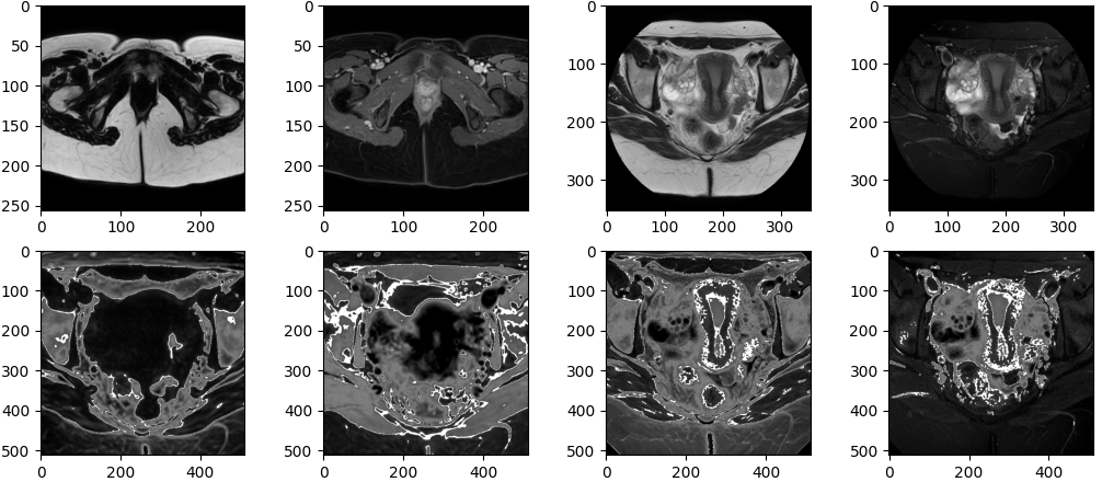

In [8]:
def interactive_image_visualization(img_no, img_slice):
  patient_img = os.path.basename(images[img_no])
  patient_label = os.path.basename(labels[img_no])

  original_image = sitk.ReadImage(images[img_no])
  original_label = sitk.ReadImage(labels[img_no])

  img_array = sitk.GetArrayFromImage(original_image)[img_slice, :, :]
  lbl_array = sitk.GetArrayFromImage(original_label)[img_slice, :, :]

  masked_data = np.ma.masked_where(lbl_array == 0, lbl_array)

  plt.figure("check", (18, 6))
  plt.subplot(1, 3, 1)
  plt.title(f"Original Image" + patient_img)
  plt.imshow(img_array, cmap='gray')
  plt.subplot(1, 3, 2)
  plt.title(f"Original GT" + patient_label)
  plt.imshow(lbl_array, cmap='gray')
  plt.subplot(1, 3, 3)
  plt.title(f"Overlay")
  plt.imshow(img_array, cmap='gray')
  plt.imshow(masked_data, cmap='viridis', alpha=0.8)


interactive(interactive_image_visualization, img_no=(0,len(images)), img_slice=(0,47))

interactive(children=(IntSlider(value=20, description='img_no', max=40), IntSlider(value=23, description='img_…

## Divisão do dataset

Nesta seção dividimos o dataset em partes para treino, validação e teste, é possivel adicionar transformadas para realizar data augmentation.

In [9]:
# Dataset utilizando a classe ImageDataset
# Responsavel por tratar metadados das imagens
class TestCompose(Compose):
    def __call__(self, data, meta, **_kwargs):
        data = self.transforms[0](data)  # ensure channel first
        data = self.transforms[1](data)  # spacing
        meta = data.meta
        if len(self.transforms) == 3:
            return self.transforms[2](data), meta  # image contrast
        return data, meta

img_trans = TestCompose([
    EnsureChannelFirst(),
    ScaleIntensity(),
    DivisiblePad(k=32),
])

label_trans = TestCompose([
    EnsureChannelFirst(),
    ScaleIntensity(),
    DivisiblePad(k=32),
])

img_dataset = ImageDataset(
    image_files=images,
    seg_files=labels,
    transform=img_trans,
    seg_transform=label_trans,
    image_only=False,
    transform_with_metadata=True,
)

train_partition = 0.8
val_partition = 0.1
test_partition = 0.1

total_size = len(img_dataset)
train_size = int(train_partition * total_size)
val_size = int(val_partition * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(img_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])
saver = SaveImage(output_dir="/content/drive/MyDrive/Colab Notebooks/EndoSeg_out", output_ext=".png", output_postfix="seg", scale=255)

print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")
print(f"Shape of images: {train_dataset[0][0].shape}")

Train set size: 32
Validation set size: 4
Test set size: 4
Shape of images: torch.Size([1, 512, 512, 64])


## Arquitetura dos modelos

Nesta seção definimos os modelos que serão utilizados no trabalho, o artigo de referencia utiliza um classificador e um modelo de segmentação, no momento recriamos somente a tarefa de segmentação para facilitar o desenvolvimento.

Um classificador pode ser realizado para reconhecer o tipo de ressonancia magnetica de entrada e chamar um modelo de segmentação especializado para aquele tipo, mas não é o objetivo atual.

In [10]:
##########################################
### MODEL PIPELINE
##########################################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# @title
# ResClass
# It was trained on 2D MRI slices from all training subjects, utilizing 3,252 slices for training and 2,168 slices for validation.
# The model architecture is a two-layer 2D ResNet18 with 8 and 16 features in the respective layers.
# Binary Cross Entropy with Logits Loss (BCEWithLogitsLoss) was used to train the classifier

classification_model = monai.networks.nets.ResNetFeatures(model_name="resnet18").to(device)

resclass_loss = torch.nn.BCEWithLogitsLoss()

optimizer_classification = torch.optim.Adam(classification_model.parameters(), lr=1e-4)

In [11]:
# AttUSeg
# 594 MRI slices for training and 136 MRI slices for validation.
# This model was developed using a four-layer Attention U-Net architecture, with 16, 32, 64, and 128 features in each layer.
# The Focal Tversky Loss function, with parameters α = 0.8, β = 0.2, and γ = 1.33, was employed for training
# To mitigate overfitting, we increased the size of the validation set,
# incorporated a dropout layer with a probability of 0.2, and applied L2 regularization

segmentation_model = monai.networks.nets.AttentionUnet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2, 2),
    dropout=0.2,
).to(device)

model_name = "AttUnet"
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(segmentation_model.parameters(), lr=1e-4, weight_decay=1e-5)

In [ ]:
segmentation_model = monai.networks.nets.UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    dropout=0.2,
).to(device)

model_name = "UNet"
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(segmentation_model.parameters(), lr=1e-4, weight_decay=1e-5)

In [ ]:
# @title
segmentation_model = smp.UnetPlusPlus(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=1,
    classes=2,
    activation=None,
).to(device)

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(segmentation_model.parameters(), 1e-4, weight_decay=1e-5)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [ ]:
%load_ext tensorboard

train_log_dir = "logs/train_data/" + datetime.now().strftime("%Y%m%d-%H%M%S")
plots_log_dir = "logs/plots/" + datetime.now().strftime("%Y%m%d-%H%M%S")

In [ ]:
# @title
# Helper class to adapt 3D data for 2D model processing (Slice-by-Slice)
class SliceAdapter(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        # Check if input is 5D: (Batch, Channel, Height, Width, Depth)
        if x.dim() == 5:
            b, c, h, w, d = x.shape
            # Permute to (Batch, Depth, Channel, Height, Width) and flatten to (Batch*Depth, Channel, Height, Width)
            x = x.permute(0, 4, 1, 2, 3).reshape(b * d, c, h, w)

            out = self.model(x)

            # Output is (Batch*Depth, NumClasses, Height, Width)
            # Restore 3D structure: (Batch, NumClasses, Height, Width, Depth)
            nc = out.shape[1]
            out = out.reshape(b, d, nc, h, w).permute(0, 2, 3, 4, 1)
            return out
        return self.model(x)

# Wrap the 2D model with the adapter
adapter = SliceAdapter(segmentation_model).to(device)

max_epochs = 10
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
writer = SummaryWriter()

model_name = "UNet++"
torch_save_path = '/content/drive/MyDrive/Colab Notebooks/Trained Weights/torch_best_metric' + model_name + '_' + str(max_epochs) + '.pth'
smp_save_path = '/content/drive/MyDrive/Colab Notebooks/Trained Weights/smp_best_metric' + model_name + '_' + str(max_epochs) + '.pth'

# Define metric for training
train_dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
# Define metric for validation (same configuration as training)
val_dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

for epoch in range(max_epochs):
    print("------------------------------")
    print(f"epoch {epoch + 1}/{max_epochs}")
    segmentation_model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()

        # Use adapter for forward pass (handles 3D -> 2D slicing)
        outputs = adapter(inputs)

        # Apply Softmax to get probabilities (since outputs are logits)
        # outputs shape: [B, 2, H, W, D]
        probs = torch.softmax(outputs, dim=1)

        # Extract foreground channel (index 1) to match binary label
        # labels shape: [B, 1, ...]
        # probs[:, 1:2, ...] keeps shape [B, 1, ...]
        foreground_probs = probs[:, 1:2, ...]

        # Tensors must be contiguous before passing to view()
        #loss = focal_tversky_torch(labels.contiguous(), foreground_probs.contiguous())
        loss = loss_function(outputs, labels)

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        # Compute Train Dice
        train_outputs_list = [post_trans(i) for i in decollate_batch(outputs)]
        train_labels_list = decollate_batch(labels)
        train_dice_metric(y_pred=train_outputs_list, y=train_labels_list)

        epoch_len = len(train_loader)
        #print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss_step", loss.item(), epoch_len * epoch + step)

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)

    # Aggregate and reset Train Dice
    train_dice = train_dice_metric.aggregate().item()
    train_dice_metric.reset()

    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}, average dice: {train_dice:.4f}")

    # Log Train Metrics
    writer.add_scalar("train_loss_epoch", epoch_loss, epoch + 1)
    writer.add_scalar("train_dice_epoch", train_dice, epoch + 1)

    if (epoch + 1) % val_interval == 0:
        segmentation_model.eval()
        with torch.no_grad():
            val_images = None
            val_labels = None
            val_outputs_raw = None
            val_epoch_loss = 0
            val_step = 0

            for val_data in val_loader:
                val_step += 1
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                roi_size = (96, 96, 16)
                sw_batch_size = 4

                # Use adapter as predictor in sliding window inference
                val_outputs_raw = sliding_window_inference(val_images, roi_size, sw_batch_size, adapter)

                # Compute Validation Loss
                val_probs = torch.softmax(val_outputs_raw, dim=1)
                val_foreground_probs = val_probs[:, 1:2, ...]
                #val_loss = focal_tversky_torch(val_labels.contiguous(), val_foreground_probs.contiguous())
                val_loss = loss_function(val_outputs_raw, val_labels)
                val_epoch_loss += val_loss.item()

                val_outputs_list = [post_trans(i) for i in decollate_batch(val_outputs_raw)]
                val_labels_list = decollate_batch(val_labels)
                # compute metric for current iteration
                val_dice_metric(y_pred=val_outputs_list, y=val_labels_list)

            val_epoch_loss /= val_step

            # aggregate the final mean dice result
            metric = val_dice_metric.aggregate().item()
            # reset the status for next validation round
            val_dice_metric.reset()
            metric_values.append(metric)

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(segmentation_model.state_dict(), torch_save_path)
                segmentation_model.save_pretrained(smp_save_path)
                print("saved new best metric model")

            print(
                "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                    epoch + 1, metric, best_metric, best_metric_epoch
                )
            )

            # Log Validation Metrics
            writer.add_scalar("val_loss_epoch", val_epoch_loss, epoch + 1)
            writer.add_scalar("val_mean_dice", metric, epoch + 1)

            # plot the last model output as GIF image in TensorBoard with the corresponding image and label
            # Only every 20 epochs
            if (epoch + 1) % 20 == 0:
                plot_2d_or_3d_image(val_images, epoch + 1, writer, index=0, tag="image")
                plot_2d_or_3d_image(val_labels, epoch + 1, writer, index=0, tag="label")
                plot_2d_or_3d_image(val_outputs_raw, epoch + 1, writer, index=0, tag="output")


print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.flush()
writer.close()

In [ ]:
# @title
def plot_validation(mri_image, labels, model_out):

  fig = plt.figure("check", (18, 6))
  plt.subplot(1, 3, 1)
  plt.title(f"Original Image")
  plt.imshow(mri_image, cmap='gray')
  plt.subplot(1, 3, 2)
  plt.title(f"Original GT")
  plt.imshow(labels, cmap='gray')
  plt.subplot(1, 3, 3)
  plt.title(f"Model output")

  return fig

In [ ]:
max_epochs = 50
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
writer = SummaryWriter()

torch_save_path = '/content/drive/MyDrive/Colab Notebooks/Trained Weights/torch_best_metric' + model_name + '_' + str(max_epochs) + '.pth'
smp_save_path = '/content/drive/MyDrive/Colab Notebooks/Trained Weights/smp_best_metric' + model_name + '_' + str(max_epochs) + '.pth'

# Define metric for training
train_dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

for epoch in range(max_epochs):
    print("-------------------------")
    print(f"epoch {epoch + 1}/{max_epochs}")
    segmentation_model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)

        optimizer.zero_grad()

        # Use adapter for forward pass (handles 3D -> 2D slicing)
        outputs = segmentation_model(inputs)

        # Use the predefined loss_function (DiceLoss) which correctly handles model outputs and labels
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_dataset) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    # Log training loss to TensorBoard
    writer.add_scalar("train_loss", epoch_loss, epoch + 1)

    if (epoch + 1) % val_interval == 0:
        segmentation_model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                roi_size = (96, 96, 16)
                sw_batch_size = 4

                # Use adapter as predictor for sliding window
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, segmentation_model)

                val_outputs_list = [post_trans(i) for i in decollate_batch(val_outputs)]
                val_labels_list = decollate_batch(val_labels)
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs_list, y=val_labels_list)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)

            # Log validation metric to TensorBoard
            writer.add_scalar("val_mean_dice", metric, epoch + 1)

            # Log sample images to TensorBoard
            #writer.add_figure("Validation", plot_validation(val_inputs, val_labels, val_outputs), global_step=epoch * len(train_loader) + i)
            plot_2d_or_3d_image(val_inputs, epoch + 1, writer, index=0, tag="image")
            plot_2d_or_3d_image(val_labels, epoch + 1, writer, index=0, tag="label")
            plot_2d_or_3d_image(val_outputs, epoch + 1, writer, index=0, tag="output")

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(segmentation_model.state_dict(), torch_save_path)
                #segmentation_model.save_pretrained(smp_save_path)
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )


print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.flush()
writer.close()

-------------------------
epoch 1/50
1/32, train_loss: 0.6491
2/32, train_loss: 0.6488
3/32, train_loss: 0.6477
4/32, train_loss: 0.6445
5/32, train_loss: 0.6453
6/32, train_loss: 0.6463
7/32, train_loss: 0.6401
8/32, train_loss: 0.6446
9/32, train_loss: 0.6448
10/32, train_loss: 0.6397
11/32, train_loss: 0.6320
12/32, train_loss: 0.6381
13/32, train_loss: 0.6417
14/32, train_loss: 0.6359
15/32, train_loss: 0.6387
16/32, train_loss: 0.6385
17/32, train_loss: 0.6408
18/32, train_loss: 0.6379
19/32, train_loss: 0.6350
20/32, train_loss: 0.6370
21/32, train_loss: 0.6307
22/32, train_loss: 0.6316
23/32, train_loss: 0.6253
24/32, train_loss: 0.6299
25/32, train_loss: 0.6283
26/32, train_loss: 0.6303
27/32, train_loss: 0.6329
28/32, train_loss: 0.6310
29/32, train_loss: 0.6288
30/32, train_loss: 0.6265
31/32, train_loss: 0.6260
32/32, train_loss: 0.6292
epoch 1 average loss: 0.6368
-------------------------
epoch 2/50
1/32, train_loss: 0.6248
2/32, train_loss: 0.6297
3/32, train_loss: 0.6280

/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:226: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:345.)
  win_data = torch.cat([inputs[win_slice] for win_slice in unravel_slice]).to(sw_device)
/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:370: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:345.)
  out

saved new best metric model
current epoch: 2 current mean dice: 0.4359
best mean dice: 0.4359 at epoch: 2
-------------------------
epoch 3/50
1/32, train_loss: 0.6116
2/32, train_loss: 0.6077
3/32, train_loss: 0.6041
4/32, train_loss: 0.6061
5/32, train_loss: 0.6063
6/32, train_loss: 0.6087
7/32, train_loss: 0.6091
8/32, train_loss: 0.5968
9/32, train_loss: 0.6084
10/32, train_loss: 0.6041
11/32, train_loss: 0.6040
12/32, train_loss: 0.6000
13/32, train_loss: 0.6064
14/32, train_loss: 0.6081
15/32, train_loss: 0.6047
16/32, train_loss: 0.6050
17/32, train_loss: 0.6002
18/32, train_loss: 0.6029
19/32, train_loss: 0.6039
20/32, train_loss: 0.5886
21/32, train_loss: 0.6010
22/32, train_loss: 0.5982
23/32, train_loss: 0.5999
24/32, train_loss: 0.6006
25/32, train_loss: 0.5958
26/32, train_loss: 0.6045
27/32, train_loss: 0.5948
28/32, train_loss: 0.5917
29/32, train_loss: 0.5933
30/32, train_loss: 0.5994
31/32, train_loss: 0.5926
32/32, train_loss: 0.5983
epoch 3 average loss: 0.6018
-----

In [ ]:
# FECHAR ESSA CELULA ANTES DE DESLIGAR O AMBIENTE!!!

%tensorboard --logdir='/content/runs/Feb12_23-15-16_e02747ad0f08'

In [ ]:
import shutil
import os

# Define source (current runtime logs) and destination (Drive) paths
source_path = '/content/runs/Feb13_18-43-53_fcd1c1d2138a'
destination_path = '/content/drive/MyDrive/TensorBoard_Logs/Feb13_18-43-53_fcd1c1d2138a'

try:
    # Copy the entire directory tree
    shutil.copytree(source_path, destination_path)
    print(f"TensorBoard logs successfully saved to: {destination_path}")
except FileExistsError:
    print(f"Log directory already exists at: {destination_path}")
except Exception as e:
    print(f"Error saving logs: {e}")

TensorBoard logs successfully saved to: /content/drive/MyDrive/TensorBoard_Logs/Feb13_18-43-53_fcd1c1d2138a


Plotagem da Loss e da metrica DICE utilizada.

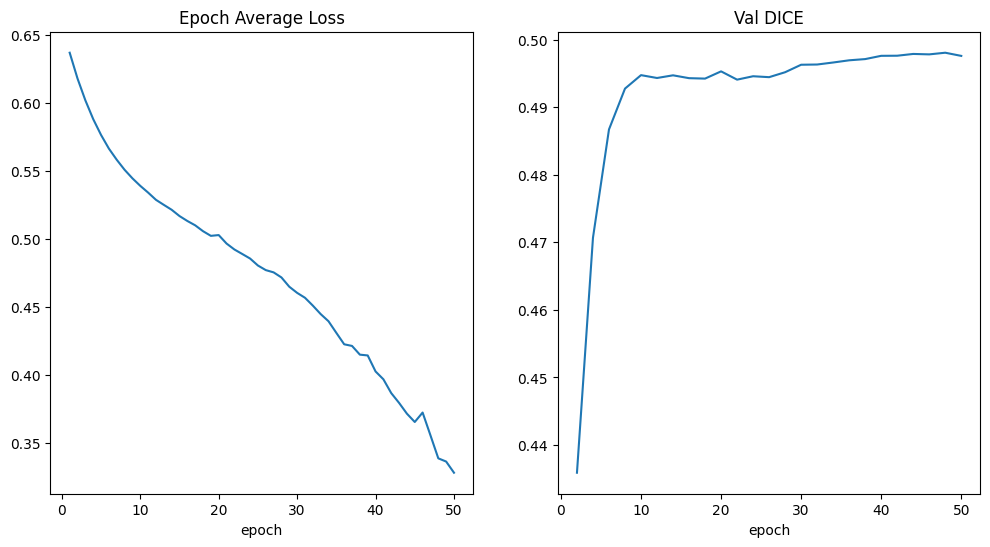

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val DICE")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

# Teste e Inferencia

Apos treinamento e validacao do modelo, seguimos para o teste, com outras imagens do nosso dataset que nao foram usadas anteriormente.


In [ ]:
# @title
#segmentation_model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Trained Weights/torch_best_metricUNet++_400.pth', weights_only=True))
#segmentation_model = smp.from_pretrained('/content/drive/MyDrive/Colab Notebooks/Trained Weights/smp_best_metricUNet++_400.pth')

# Helper class to adapt 3D data for 2D model processing (Slice-by-Slice)
# Redefining here to ensure it exists for inference
class SliceAdapter(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        # Check if input is 5D: (Batch, Channel, Height, Width, Depth)
        if x.dim() == 5:
            b, c, h, w, d = x.shape
            # Permute to (Batch, Depth, Channel, Height, Width) and flatten to (Batch*Depth, Channel, Height, Width)
            x = x.permute(0, 4, 1, 2, 3).reshape(b * d, c, h, w)

            out = self.model(x)

            # Output is (Batch*Depth, NumClasses, Height, Width)
            # Restore 3D structure: (Batch, NumClasses, Height, Width, Depth)
            nc = out.shape[1]
            out = out.reshape(b, d, nc, h, w).permute(0, 2, 3, 4, 1)
            return out
        return self.model(x)

segmentation_model.eval()
# Use the adapter for inference to handle 3D inputs
adapter = SliceAdapter(segmentation_model).to(device)
adapter.eval()

dice_metric.reset()
test_inferences = list()

with torch.no_grad():
    for test_data in test_loader:
        roi_size = (96, 96, 16)
        sw_batch_size = 4

        # Move data to device
        test_images = test_data[0].to(device)
        test_labels = test_data[1].to(device)

        # Inference using the adapter
        test_outputs = sliding_window_inference(test_images, roi_size, sw_batch_size, adapter)

        # Compute Metric
        # Apply post-processing to predictions
        test_pred_post = [post_trans(x) for x in decollate_batch(test_outputs)]
        # Decollate labels
        test_labels_list = decollate_batch(test_labels)
        # Calculate Dice
        dice_metric(y_pred=test_pred_post, y=test_labels_list)
        test_inferences.append(test_outputs)


# Aggregate and print metric
mean_dice_test = dice_metric.aggregate().item()
dice_metric.reset()
print(f"Mean Dice score on Test set: {mean_dice_test:.4f}")

In [12]:
segmentation_model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Trained Weights/torch_best_metricAttUnet_50.pth', weights_only=True))
segmentation_model.eval()

dice_metric.reset()
test_inferences = list()

with torch.no_grad():
    for test_data in test_loader:
        roi_size = (96, 96, 16)
        sw_batch_size = 4

        # Move data to device
        test_images = test_data[0].to(device)
        test_labels = test_data[1].to(device)

        # Inference using the adapter
        test_outputs = sliding_window_inference(test_images, roi_size, sw_batch_size, segmentation_model)

        # Compute Metric
        # Apply post-processing to predictions
        test_pred_post = [post_trans(x) for x in decollate_batch(test_outputs)]
        # Decollate labels
        test_labels_list = decollate_batch(test_labels)
        # Calculate Dice
        dice_metric(y_pred=test_pred_post, y=test_labels_list)
        test_inferences.append(test_outputs)


# Aggregate and print metric
mean_dice_test = dice_metric.aggregate().item()
dice_metric.reset()
print(f"Mean Dice score on Test set: {mean_dice_test:.4f}")

/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:226: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:347.)
  win_data = torch.cat([inputs[win_slice] for win_slice in unravel_slice]).to(sw_device)
/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:370: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:347.)
  out

Mean Dice score on Test set: 0.4733


In [13]:
og_test_images = list()
og_test_labels = list()

for test_data in test_loader:
  og_test_images.append(test_data[0])
  og_test_labels.append(test_data[1])

def interactive_test_image_visualization(img_no, img_slice):
  # Convert tensors to numpy arrays for visualization
  # Input Shape: (Batch, Channel, Height, Width, Depth)
  original_image = og_test_images[img_no][0, 0, :, :, img_slice].cpu().detach().numpy()
  original_label = og_test_labels[img_no][0, 0, :, :, img_slice].cpu().detach().numpy()

  # Output Shape: (Batch, Classes, Height, Width, Depth)
  original_output_logits = test_inferences[img_no]
  # Get the predicted class (0 or 1) by argmax
  original_output = torch.argmax(original_output_logits, dim=1)[0, :, :, img_slice].cpu().detach().numpy()

  # Create masked arrays for overlay visualization (0 values are transparent)
  masked_label = np.ma.masked_where(original_label == 0, original_label)
  masked_output = np.ma.masked_where(original_output == 0, original_output)

  plt.figure("check", (24, 6))

  # 1. Original Image
  plt.subplot(1, 4, 1)
  plt.title(f"Original Image")
  plt.imshow(original_image, cmap='gray')

  # 2. Ground Truth
  plt.subplot(1, 4, 2)
  plt.title(f"Ground Truth")
  plt.imshow(original_label, cmap='gray')

  # 3. Model Prediction
  plt.subplot(1, 4, 3)
  plt.title(f"Model Prediction")
  plt.imshow(original_output, cmap='gray')

  # 4. Overlay (GT vs Prediction)
  # Shows GT in Green and Prediction in Red over the original image
  plt.subplot(1, 4, 4)
  plt.title(f"Overlay (GT: Green, Pred: Red)")
  plt.imshow(original_image, cmap='gray')
  # Ground Truth in Green
  plt.imshow(masked_label, cmap='Greens', alpha=0.8, vmin=0, vmax=1)
  # Prediction in Red
  plt.imshow(masked_output, cmap='Reds', alpha=0.8, vmin=0, vmax=1)

  plt.show()


interactive(interactive_test_image_visualization, img_no=(0,len(og_test_images)-1), img_slice=(0,63))

interactive(children=(IntSlider(value=1, description='img_no', max=3), IntSlider(value=31, description='img_sl…